~~~
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/path-foundation/blob/master/notebooks/fine_tune_data_efficient_classifier_gcs.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/path-foundation/blob/master/notebooks/fine_tune_data_efficient_classifier_gcs.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/path-foundation">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
  <td style="text-align: center">
  <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fcxr-foundation%2Fmaster%2Fnotebooks%2Ffine_tune_data_efficient_classifier.ipynb">
    <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
  </a>
</td>
</tr></tbody></table>


# Fine-tuning the Hugging Face Pathology Model for Classification

This notebook demonstrates how to fine-tune the Hugging Face `path-foundation` model for binary classification of pathology images. It uses a subset of the [CAMELYON16](https://camelyon16.grand-challenge.org/) dataset (containing lymph node images) to train the model to distinguish between cancerous and benign tissues. The notebook covers the entire workflow: downloading and preparing the dataset, fine-tuning the pre-trained model using TensorFlow and Keras, and finally, evaluating the model's performance on a held-out evaluation set.

**Additional details**: For this demo, patches sampled from whole slide images (WSIs) are downloaded from Google Cloud Storage. A subset of the patches will be sampled randomly from across all available slides and be prepared for finetuning.

**Dataset**: This notebook uses the [CAMELYON16](https://camelyon16.grand-challenge.org/) dataset, which contains WSIs from lymph node specimens with and without metastatic breast cancer. Any work that uses this dataset should consider additional details along with usage and citation requirements listed on [their website](https://camelyon17.grand-challenge.org/Data/).

**Dataset citation**: Babak Ehteshami Bejnordi; Mitko Veta; Paul Johannes van Diest; Bram van Ginneken; Nico Karssemeijer; Geert Litjens; Jeroen A. W. M. van der Laak; and the CAMELYON16 Consortium. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA. 2017;318(22):2199–2210. DOI: 10.1001/jama.2017.14585

> **NOTE:** This colab does fine-tuning so it is recommanded to use a colab kernal with a GPU.

In [ ]:
# @title Authenticate with Hugging Face
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
  from huggingface_hub import notebook_login
  notebook_login()
else:
  print('Token already set.')

Used secret


In [ ]:
# @title Fetch HuggingFace model

from huggingface_hub import from_pretrained_keras
model_hf = from_pretrained_keras('google/path-foundation', compile=False)

In [ ]:
# @title Select a random subset of imaging for training and evaluation, then copy locally
%%capture

import os
import random

# Settings for dataset
randomize_dataset = "False"  # @param ["True", "False"]
TRAINING_SIZE = 32
EVAL_SIZE = 24
BUCKET_PREFIX = "gs://healthai-us/"

# Define the commands to fetch and prepare datasets
def fetch_file_names(category, division, size):
    path = f"pathology/{division}/{category}"
    !mkdir -p {path}
    # Fetch file names using gsutil
    full_paths = !gsutil ls {BUCKET_PREFIX}{path}/**
    if randomize_dataset:
        full_paths = random.sample(full_paths, len(full_paths))
    selected_paths = full_paths[:size]
    file_urls = ' '.join(selected_paths)
    !gsutil -m cp -n {file_urls} {path}
    # Select required number of examples and strip the bucket prefix
    return [fp.replace(BUCKET_PREFIX, '') for fp in selected_paths]

# Collect file paths for each category and division
cancer_imaging_training = fetch_file_names('cancer', 'training', TRAINING_SIZE)
benign_imaging_training = fetch_file_names('benign', 'training', TRAINING_SIZE)
cancer_imaging_eval = fetch_file_names('cancer', 'eval', EVAL_SIZE)
benign_imaging_eval = fetch_file_names('benign', 'eval', EVAL_SIZE)


In [ ]:
# @title Images to model inputs
from PIL import Image as PILImage
import tensorflow as tf
import numpy as np

def image_path_to_input_tensor(path):
  """
  Opens an image file, converts it to a TensorFlow tensor, and scales pixel
  values to the range [0, 1]. Images in the dataset used in this colab are
  already 224x224 pixels. In other cases, you must crop your images to this size
  before passing them to the model.
  """
  img = PILImage.open(path).convert('RGB')
  return tf.cast(tf.expand_dims(np.array(img), axis=0), tf.float32) / 255.0

training_cancer_normalized_images = [
    image_path_to_input_tensor(path) for path in cancer_imaging_training]
training_benign_normalized_images = [
    image_path_to_input_tensor(path) for path in benign_imaging_training]
eval_cancer_normalized_images = [
    image_path_to_input_tensor(path) for path in cancer_imaging_eval]
eval_benign_normalized_images = [
    image_path_to_input_tensor(path) for path in benign_imaging_eval]

In [ ]:
# @title Finetune HuggingFace model (<1 minute on GPU, ~15 minutes on CPU)

import random
import tensorflow as tf
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
from huggingface_hub import from_pretrained_keras

print("""
  Fine-tuning this model might take a while (<1 minute on GPU, ~15 minutes on CPU), 
  depending on your Colab runtime's resources. Please be patient.
  """)

@register_keras_serializable()
class EmbeddingLayer(Layer):
  """A custom Keras layer that wraps a pre-trained embedding model for fine-tuning."""

  def __init__(self, model, model_name='google/path-foundation', **kwargs):
    """ Initialize the EmbeddingLayer with a pre-trained model. """
    super().__init__(**kwargs)
    self.embedding_model = model
    self.model_name = model_name


  @tf.function
  def call(self, inputs):
    """ Compute embeddings by passing inputs through the embedding model. """
    return self.embedding_model(inputs)

  def get_config(self):
    """ Return the configuration dictionary of the layer for serialization. """
    config = super().get_config()
    config.update({
        'model_name': self.model_name
    })
    return config

  @classmethod
  def from_config(cls, config):
    """ Instantiate an EmbeddingLayer from a configuration dictionary. """
    model_name = config.pop('model_name')
    embedding_model = from_pretrained_keras(model_name, compile=False)
    return cls(model=embedding_model, model_name=model_name, **config)


# Total number of classes for classification.
NUM_CLASSES = 2

with tf.device('/GPU:0'):
    # Wrap the pre-trained model in a custom embedding layer
    embedding_layer = EmbeddingLayer(model_hf, name='embedding')

    # Add a dense output layer for classification
    classification_layer = Dense(NUM_CLASSES, activation='softmax', dtype='float32', name='classification_output')

    # Build the new sequential model for pathology image classification,
    # consisting of an embedding layer, dropout for regularization, and a classification layer.
    new_model = Sequential([embedding_layer, Dropout(0.1), classification_layer], name='path_classifer')

    # Combine cancer and benign images into a single training dataset, assigning labels:
    # 1 for cancer images, 0 for benign images.
    training_images = tf.concat(training_cancer_normalized_images + training_benign_normalized_images, axis=0)
    training_labels = tf.constant([1] * len(training_cancer_normalized_images) + [0] * len(training_benign_normalized_images))

    # Similarly, prepare evaluation images and labels.
    eval_images = tf.concat(eval_cancer_normalized_images + eval_benign_normalized_images, axis=0)
    eval_labels = tf.constant([1] * len(eval_cancer_normalized_images) + [0] * len(eval_benign_normalized_images))


    # Callbacks:
    # - ReduceLROnPlateau lowers the learning rate when val_loss stops improving.
    # - EarlyStopping stops training early if val_loss doesn't improve, restoring the best weights.
    lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # Using a small batch size (8) for more frequent updates and potentially better generalization.
    # Starting with a relatively high learning rate (0.05) for the full model,
    # but we rely on ReduceLROnPlateau and EarlyStopping to control overfitting and stabilize training.

    # Unfreeze the embedding layer and train the entire model to boost performence.
    embedding_layer.trainable = True
    classification_layer.trainable = True
    new_model.compile(optimizer=Adam(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
    new_model.fit(
        training_images,
        to_categorical(training_labels, num_classes=NUM_CLASSES),
        epochs=40,
        batch_size=8,
        validation_data=(
            eval_images,
            to_categorical(eval_labels, num_classes=NUM_CLASSES)
        ),
        callbacks=[lr_callback, early_stopping]
    )

    # Display fine-tuned model details.
    new_model.summary()

    # Save the fine-tuned model to disk
    new_model.save('fine_tuned_model.keras')




  Fine-tuning this model might take a while (<1 minute on GPU, ~15 minutes on CPU),
  depending on your Colab runtime's resources. Please be patient.
  
Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.6842 - loss: 3.7341 - val_accuracy: 0.9375 - val_loss: 1.2672 - learning_rate: 0.0500
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9549 - loss: 0.5374 - val_accuracy: 0.8333 - val_loss: 3.3702 - learning_rate: 0.0500
Epoch 3/40
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9682 - loss: 0.3486
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9614 - loss: 0.4034 - val_accuracy: 0.8542 - val_loss: 5.3358 - learning_rate: 0.0500
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9759 - loss: 0.1372 - val_accuracy: 0.8750 - val_loss: 4.6162 - learning_rate: 0.0250
Epoch 5/40
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 7.1559e-06
Epoch 5: Reduce

Model: "path_classifer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (EmbeddingLayer)           │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_output (Dense)        │ (None, 2)                   │             770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,312 (9.04 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,542 (6.03 KB)

In [ ]:
# @title Perform Inference using the Fine-tuned Model

# Load the fine-tuned model from disk
from tensorflow.keras.models import load_model
model_finetuned = load_model('fine_tuned_model.keras', compile=False)

np.set_printoptions(formatter={'float_kind': lambda x: "{:.6f}".format(x)})

eval_predictions = []
eval_ground_truth = []

print('\n\nEach prediction is a probability distribution over [benign, cancer].')
print('For example: [0.123, 0.877] means a ~12.3% chance benign and ~87.7% chance cancer.')
print('\n\nRun prediction for eval set:')

print('=== Ground truth: cancer ===')
for image in eval_cancer_normalized_images:
  prediction = model_finetuned(image).numpy()
  eval_predictions.append(prediction[0][1])
  eval_ground_truth.append(1)  # 1 for cancer
  print('Predictions for [benign, cancer]:', prediction)

print('\n=== Ground truth: benign ===')
for image in eval_benign_normalized_images:
  prediction = model_finetuned(image).numpy()
  eval_predictions.append(prediction[0][1])
  eval_ground_truth.append(0)  # 0 for benign
  print('Predictions for [benign, cancer]:', prediction)



Each prediction is a probability distribution over [benign, cancer].
For example: [0.123, 0.877] means a ~12.3% chance benign and ~87.7% chance cancer.


Run prediction for eval set:
=== Ground truth: cancer ===
Predictions for [benign, cancer]: [[0.000018 0.999982]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000183 0.999817]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000009 0.999991]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Predictions for [benign, cancer]: [[0.000000 1.000000]]
Pr

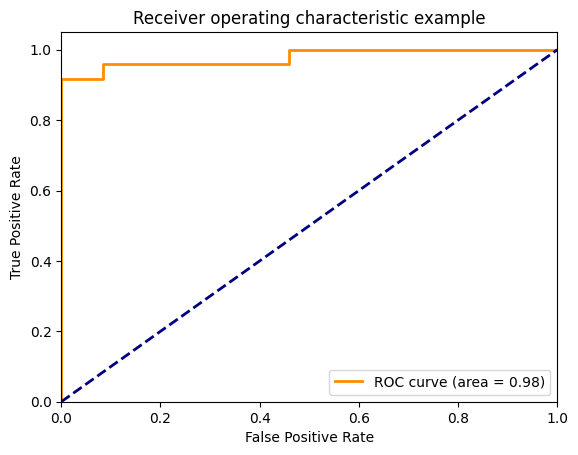

AUC score: 0.9739583333333333


In [36]:
# @title Plot AUC graph

import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(eval_ground_truth, eval_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

print('AUC score:',sklearn.metrics.roc_auc_score(eval_ground_truth, eval_predictions))

In [39]:
import sklearn.metrics
import numpy as np

# @title Find Youden's index for threshold selection

thresholds = np.linspace(0, 1, 100)
sensitivities = []
specificities = []

# Convert eval_ground_truth to a NumPy array
eval_ground_truth_array = np.array(eval_ground_truth)

# Iterate through thresholds and calculate sensitivity and specificity for each
for threshold in thresholds:
  predictions = np.array(eval_predictions) > threshold  # Convert predictions to NumPy array
  sensitivities.append(sklearn.metrics.recall_score(eval_ground_truth_array, predictions))
  specificities.append(
      sklearn.metrics.recall_score(eval_ground_truth_array == 0, predictions == 0)
  )

# Find the index of the maximum Youden's index
index = np.argmax(np.array(sensitivities) + np.array(specificities))
best_threshold = thresholds[index]
sens = sensitivities[index]
spec = specificities[index]
print(
    f"Best threshold: {round(best_threshold,2)}. Sensitivity is"
    f" {round(sens*100,2)}% and Specificity is {round(spec*100,2)}% "
)

Best threshold: 0.4. Sensitivity is 91.67% and Specificity is 100.0% 


> **NOTE:** This demo randomly samples a subset of patches. Therefore, the exact results will vary from run to run.

# Next steps

 Explore the other [notebooks](https://github.com/google-health/path-foundation/blob/master/notebooks).